In [1]:
import random
import numpy as np

import simpy


from dataclasses import dataclass

NUM_AGENTES = 50
ANCHO_MUNDO = 100.0
ALTO_MUNDO = 100.0

ENERGIA_MAX = 10.0
TASA_RECUPERACION_NATURAL = 0.05
GASTO_POR_MOVIMIENTO = 0.08
EFECTO_INTERACCION = 0.02

NUM_PUESTOS_RECARGA = 5
ENERGIA_CRITICA = 2.0
TIEMPO_RECARGA = 10.0

TIEMPO_SIMULACION = 500.0
DT = 1.0
RADIO_INTERACCION = 5.0

@dataclass
class MedidasPaso:
    t: float
    energia_media: float
    en_cola: int
    en_servicio: int

class Agente:
    def __init__(self, id_agente, env, estacion):
        self.id = id_agente
        self.env = env
        self.estacion = estacion
        self.pos = np.array([random.uniform(0, ANCHO_MUNDO), random.uniform(0, ALTO_MUNDO)], dtype=float)
        ang = random.uniform(0, 2.0*np.pi)
        v = random.uniform(0.5, 1.5)
        self.vel = np.array([v*np.cos(ang), v*np.sin(ang)], dtype=float)
        self.energia = ENERGIA_MAX
        self.en_recarga = False

    def proceso_recarga(self):
        self.en_recarga = True
        with self.estacion.request() as req:
            yield req
            yield self.env.timeout(TIEMPO_RECARGA)
            self.energia = ENERGIA_MAX
        self.en_recarga = False

    def actualizar_estado(self, efecto_interaccion, dt):
        inflow = TASA_RECUPERACION_NATURAL
        outflow = GASTO_POR_MOVIMIENTO + abs(efecto_interaccion)
        self.energia += dt*(inflow - outflow)
        self.energia = max(0.0, min(ENERGIA_MAX, self.energia))
        self.pos += self.vel * dt
        if self.pos[0] < 0 or self.pos[0] > ANCHO_MUNDO:
            self.vel[0] *= -1
            self.pos[0] = max(0, min(ANCHO_MUNDO, self.pos[0]))
        if self.pos[1] < 0 or self.pos[1] > ALTO_MUNDO:
            self.vel[1] *= -1
            self.pos[1] = max(0, min(ALTO_MUNDO, self.pos[1]))
        if (self.energia < ENERGIA_CRITICA) and (not self.en_recarga):
            self.env.process(self.proceso_recarga())

def ejecutar_simulacion(capacidad_recarga=NUM_PUESTOS_RECARGA, tiempo_simulacion=TIEMPO_SIMULACION, dt=DT, seed=42):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    env = simpy.Environment()
    estacion = simpy.Resource(env, capacity=capacidad_recarga)
    agentes = [Agente(i, env, estacion) for i in range(NUM_AGENTES)]
    medidas = []

    def bucle():
        while env.now < tiempo_simulacion:
            efectos = [0.0]*NUM_AGENTES
            for i in range(NUM_AGENTES):
                for j in range(i+1, NUM_AGENTES):
                    d = np.linalg.norm(agentes[i].pos - agentes[j].pos)
                    if d <= RADIO_INTERACCION:
                        s = 1.0 if random.random() < 0.5 else -1.0
                        efectos[i] += s * EFECTO_INTERACCION
                        efectos[j] -= s * EFECTO_INTERACCION
            for i, ag in enumerate(agentes):
                ag.actualizar_estado(efectos[i], dt)
            energia_media = float(sum(a.energia for a in agentes)/NUM_AGENTES)
            medidas.append(MedidasPaso(env.now, energia_media, len(estacion.queue), estacion.count))
            yield env.timeout(dt)

    env.process(bucle())
    env.run(until=tiempo_simulacion)
    return medidas, agentes

In [2]:
medidas5, _ = ejecutar_simulacion(capacidad_recarga=5, tiempo_simulacion=500.0, dt=1.0, seed=123)
medidas1, _ = ejecutar_simulacion(capacidad_recarga=1, tiempo_simulacion=500.0, dt=1.0, seed=123)

def resumen(medidas):
    import math
    if not medidas: 
        return {}
    prom_e = sum(m.energia_media for m in medidas)/len(medidas)
    prom_cola = sum(m.en_cola for m in medidas)/len(medidas)
    max_cola = max(m.en_cola for m in medidas)
    prom_serv = sum(m.en_servicio for m in medidas)/len(medidas)
    return {"prom_energia": prom_e, "cola_prom": prom_cola, "cola_max": max_cola, "prom_servicio": prom_serv}

resumen_5 = resumen(medidas5)
resumen_1 = resumen(medidas1)
resumen_5, resumen_1

({'prom_energia': 5.766882400000008,
  'cola_prom': 2.608,
  'cola_max': 27,
  'prom_servicio': 1.548},
 {'prom_energia': 3.9313188000000054,
  'cola_prom': 18.696,
  'cola_max': 44,
  'prom_servicio': 0.568})

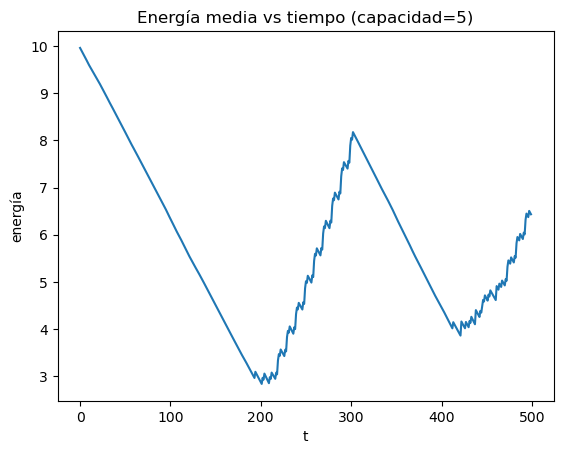

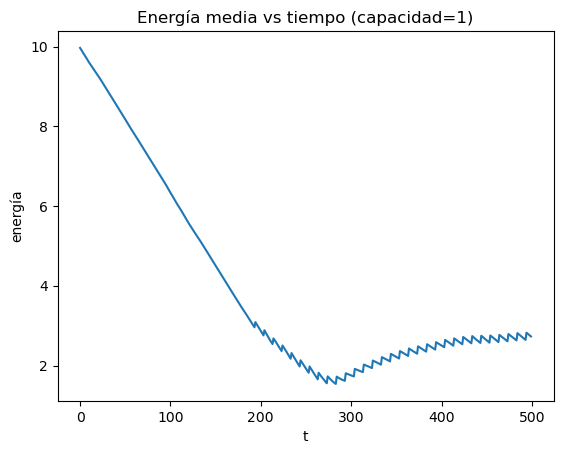

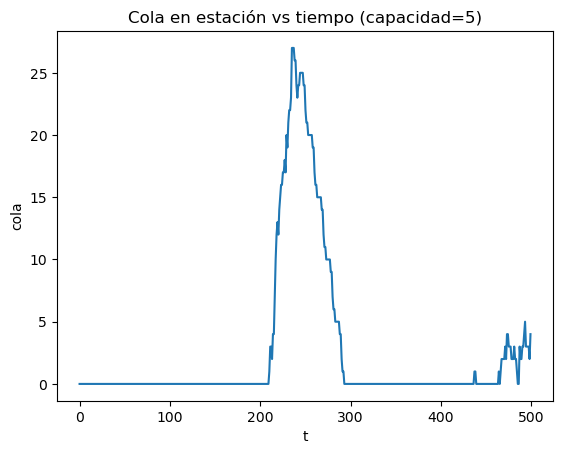

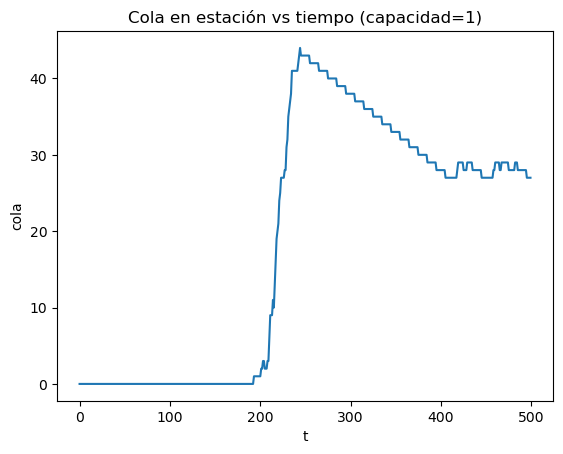

In [3]:
import matplotlib.pyplot as plt

t5 = [m.t for m in medidas5]
e5 = [m.energia_media for m in medidas5]
c5 = [m.en_cola for m in medidas5]

t1 = [m.t for m in medidas1]
e1 = [m.energia_media for m in medidas1]
c1 = [m.en_cola for m in medidas1]

plt.figure(); plt.plot(t5, e5); plt.title("Energía media vs tiempo (capacidad=5)"); plt.xlabel("t"); plt.ylabel("energía")
plt.show()

plt.figure(); plt.plot(t1, e1); plt.title("Energía media vs tiempo (capacidad=1)"); plt.xlabel("t"); plt.ylabel("energía")
plt.show()

plt.figure(); plt.plot(t5, c5); plt.title("Cola en estación vs tiempo (capacidad=5)"); plt.xlabel("t"); plt.ylabel("cola")
plt.show()

plt.figure(); plt.plot(t1, c1); plt.title("Cola en estación vs tiempo (capacidad=1)"); plt.xlabel("t"); plt.ylabel("cola")
plt.show()

## Preguntas de analisis

Ejecute la simulación con una capacidad generosa en la estación de recarga (NUM_PUESTOS_RECARGA =
5). ¿Cuántos agentes, en promedio, utilizan la estación durante la simulación? Analice los datos que
recolectó. ¿Se forman colas significativas o el servicio es fluido?

R// Con capacidad de 5 puestos, el sistema presenta un servicio mas o menos fluido. La cola promedio de 2.6 agentes indica esperas moderadas pero manejables.

Ahora, reduzca drásticamente la capacidad de la estación a NUM_PUESTOS_RECARGA = 1. ¿Cómo
impacta este cambio en la dinámica general de energía de la población? ¿Observa usted un mayor número
de agentes con energía críticamente baja durante periodos más prolongados? ¿Por qué ocurre esto?

R// El cuello de botella crea un ciclo de retroalimentación negativa es decir que los agentes con energía crítica deben esperar más tiempo para recargar, durante el cual continúan perdiendo energía por movimiento e interacciones, lo que empeora su estado.

En el escenario con NUM_PUESTOS_RECARGA = 1, la estación de recarga se convierte en un claro cuello
de botella (un fenómeno DES). ¿Qué efecto observable tiene este cuello de botella sobre el
comportamiento agregado del sistema (por ejemplo, el nivel de energía promedio de toda la población a lo
largo del tiempo, un resultado del MBA+DS)?

R// Reducción del 32% en energía promedio  de 5.77 a 3.93 y la pérdida de recuperación en capacidad 5, el sistema muestra ciclos de recuperación energética. En capacidad 1, el sistema pierde esta capacidad y se estanca en niveles bajos

Basándose en sus experimentos, describa el bucle de retroalimentación que existe entre el componente
DES (la disponibilidad de la estación de recarga) y el componente MBA+DS (la energía y el comportamiento
de la población de agentes). ¿De qué manera demuestra este ejercicio la afirmación de que en el modelado
híbrido, "el todo es más que la suma de sus partes"?

R// El bucle de retroalimentación entre DES y MBA+DS funciona con la capacidad limitada de la estación que genera colas largas, durante las cuales los agentes pierden energía por movimiento e interacciones osea MBA+DS, lo que incrementa la demanda de recarga y perpetúa las colas extensas. 